In [18]:
%load_ext autoreload
%autoreload 2

# System imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import qutip as qt


# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model_basis_change as Model_basis_change
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse

# Libs and helpers
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.envelopes as envelopes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def plot_dynamics(exp, psi_init, seq, eps_pop=1e-4):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        eps_pop: float
            Minimum of population for state to be plotted
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        for p, label in zip(pop_t, exp.pmap.model.state_labels):
            if np.max(p) > eps_pop:
                plt.plot(ts / 1e-9, p, label=label)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend()
        pass

In [20]:
def print_state(state_vec, model, eps_pop=1e-2):
    """
    Print a state in clear text
    
    Parameters
        ----------
        state_vec: np.array
            state in vector form.
        model: c3 model
            model the state belongs to
        eps_pop: float
            Minimum of population for basis state to be printed
    
    """
    string = ""
    for i, coeff in enumerate(state_vec):
        if np.abs(coeff) > eps_pop:
            string += f" + {coeff} {model.state_labels[i]}"
    print(string)


def find_plus_minus_states_q_tc_q(model, print_res=False):

    """
    Finds unitary trasnformation from bare basis to dressed +- basis in a 
    tunable coupler architecture
    
    Parameters
        ----------
        model: c3 model
            model describing a tc architecture
        print_res: bool
            determines if found states are printed

    Returns
        -------
        tf.tensor
            Unitary transformation
    """
    
    # v describes dressed basis
    e, v_tf = tf.linalg.eigh(model.drift_ham)
    # U_full is tranformation from dressed to +- basis
    U_full = np.diag([1.]*len(e))

    estates = v_tf.numpy().T

   
    # Identify + state and - state
    overlap_state = (qt.basis(list(model.dims), [1,0,0]) + qt.basis(list(model.dims), [0,1,0])).unit()
    over_tf = tf.abs(overlap_state.data.toarray()[:,0])
    overlap_list = [tf.reduce_sum(tf.multiply(over_tf, tf.abs(ev))) for ev in tf.transpose(v_tf)]
    rel_idc = np.argsort(overlap_list)[::-1][:2]
    plus_minus_list= [tf.constant(estates[rel_idc[0]], dtype=tf.float64), 
                    tf.constant(estates[rel_idc[1]], dtype=tf.float64)]
                    

    # Create transformation from dressed to +- basis
    angle = tf.expand_dims(tf.constant(np.pi/4, dtype=tf.float64), axis=0)
    U = tf.concat((tf.stack([tf.cos(angle), -tf.sin(angle)], axis=1),
                    tf.stack([tf.sin(angle), tf.cos(angle)], axis = 1)), axis=0)
    U = tf.squeeze(U)
    U_full[np.ix_(rel_idc, rel_idc)] = U.numpy()

    # Calulate new lacalized states
    e_vector_vec = tf.transpose(tf.stack(plus_minus_list, axis=1))
    state0 = tf.gather(tf.linalg.tensordot(U, e_vector_vec, 1), 0)
    state1 = tf.gather(tf.linalg.tensordot(U, e_vector_vec, 1), 1)

    if print_res:
        print_state(state0, model)
        print_state(state1, model)
    
    return tf.matmul(v_tf, tf.constant(U_full.T, dtype=tf.complex128))

In [21]:
# Tunable coupler architecture

phi_0 = Qty(1)
qubit_lvls = 3

freq_q1 = 5e9
anhar_q1 = -210e6
phi_q1 = Qty(0)
d_q1 = Qty(0.5)

q1 = chip.Transmon(
    name="Q1",
    freq=Qty(value=freq_q1, min_val=1.e9, max_val=6e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q1, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    d=d_q1,
    phi=phi_q1,
    phi_0=phi_0,
)

freq_q2 = 5e9
anhar_q2 = -210e6
phi_q2 = Qty(0)
d_q2 = Qty(0.5)

q2 = chip.Transmon(
    name="Q2",
    freq=Qty(value=freq_q2, min_val=1e9, max_val=6e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q2, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    d=d_q2,
    phi=phi_q2,
    phi_0=phi_0,
)


freq_tc = 5.5e9
anhar_tc = -210e6
phi_tc = Qty(0)
d_tc = Qty(0.5)

tc = chip.Transmon(
    name="TC",
    freq=Qty(value=freq_tc, min_val=1e9, max_val=6e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_tc, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    d=d_tc,
    phi=phi_tc,
    phi_0=phi_0,
)



coupling_strength_12 = 1e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength_12,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_YY
)

coupling_strength_1tc = 100e6
q1tc = chip.Coupling(
    name="Q1-TC",
    connected=["Q1", "TC"],
    strength=Qty(
        value=coupling_strength_1tc,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_YY
)

coupling_strength_2tc = 100e6
q2tc = chip.Coupling(
    name="Q2-TC",
    connected=["Q2", "TC"],
    strength=Qty(
        value=coupling_strength_2tc,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_YY
)

In [22]:
# Frequency drive on tc
Z_drive_tc = chip.Drive(
    name="Zd_TC",
    connected=["TC"],
    hamiltonian_func=hamiltonians.z_drive
)

In [23]:
model = Model_basis_change(
    [q1, q2, tc,], # Individual, self-contained components
    [Z_drive_tc, q1q2, q1tc, q2tc],  # Interactions between components
)
model.set_lindbladian(False)
model.update_model()

In [24]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG

# Standard devices
lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')
dig_to_an = devices.DigitalToAnalog(name="dac", resolution=sim_res)


# Frequency tuning of tunable coupler
flux_tuning = devices.FluxTuning(name="flux_tuning", phi_0=phi_0, phi=phi_tc, d=d_tc, omega_0=Qty(freq_tc, unit='Hz 2pi'), anhar=Qty(anhar_tc, unit='Hz 2pi'))


generator = Gnr(
        devices={
            "LO": lo,
            "AWG": awg,
            "DigitalToAnalog": dig_to_an,
            "Mixer": mixer,
            "flux_tuning": flux_tuning,
        },
        chains={
            # Line for frequency modulation
            "Zd_TC": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "flux_tuning": ["Mixer"],
            },
        }
    )

In [25]:
# Create an idle gate
t_final_2Q = 20e-9

gauss_params= {
    'amp': Qty(value=00, min_val=0.0, max_val=0.6, unit="V"),
    't_final': Qty(value=t_final_2Q, min_val=0.5 * t_final_2Q, max_val=1.5 * t_final_2Q, unit="s"),
    'sigma': Qty(value=t_final_2Q / 4, min_val=t_final_2Q / 8, max_val=t_final_2Q / 2, unit="s"),
}

gauss_env = pulse.EnvelopeDrag(
    name="gauss1",
    desc="Gaussian envelope on drive 1",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm
)

lo_freq = 0e6
carr = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq, min_val=-1e9, max_val=1e9, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

gate = gates.Instruction(
    name="gate", targets=[0, 1], t_start=0.0, t_end=t_final_2Q, channels=["Zd_TC"],
)
gate.add_component(gauss_env, "Zd_TC")
gate.add_component(carr, "Zd_TC")


/home/max/Documents/C3_freq_coupling/c3/c3/signal/gates.py:102: UserWarning: No ideal gate found for gate: gate. Use set_ideal() explicitly.
  warnings.warn(


In [26]:
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

In [27]:
psi_init = [[0] * 27]
psi_init[0][3] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

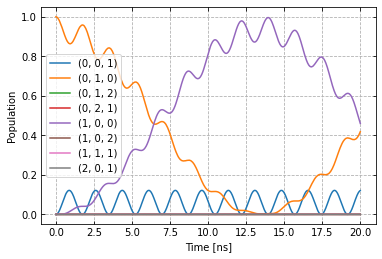

In [28]:
# Dynamics in bare basis with leakage to the coupler
sequence = [gate.get_key()]
plot_dynamics(exp, init_state, sequence)

In [29]:
# Calculate trasnformation to +- basis
U_transform = find_plus_minus_states_q_tc_q(model, print_res=True)
# Create model in new basis
model_transformed = copy.deepcopy(model)
model_transformed.U_transform = U_transform 
model_transformed.set_dressed(True)
model_transformed.update_model()

parameter_map_transformed = PMap(instructions=[gate], model=model_transformed, generator=generator)
exp_transformed = Exp(pmap=parameter_map_transformed)

 + 0.1803157588392066 (0, 0, 1) + 0.016579981257450416 (0, 1, 0) + -0.9833255210461824 (1, 0, 0) + -0.013541869546790253 (2, 0, 1)
 + -0.18031575883920498 (0, 0, 1) + 0.9833255210461822 (0, 1, 0) + 0.01354186954679036 (0, 2, 1) + -0.016579981257456577 (1, 0, 0)


/home/max/anaconda3/envs/c3-dev/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/home/max/Documents/C3_freq_coupling/c3/c3/model.py:640: UserWarning: C3 Warning: Some states are overly dressed, trying to recover...16 states, 4 is lowest failed state
  for i in range(vc.shape[1]):


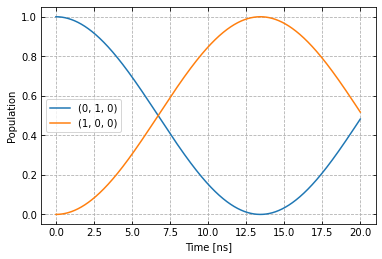

In [30]:
# Dynamics in trasnformed basis without leakage to the coupler
sequence_transformed = [gate.get_key()]
plot_dynamics(exp_transformed, init_state, sequence_transformed)